## Header 
Author : Amina Matt and Yichen Wang  
Date created : 14.10.2021  
Date last modified : 21.11.2021  
Python version : 3.8  
Description : Text processing of the CARICOM Compilation Archive (CCA) https://louverture.ch/cca/ 



# To Do List
- [X] check number items
- [X] to JSON 
- [ ] JSON person cleaning
- [ ] JSON location cleaning
- [ ] save NER 

# Initialization

In [189]:
# -*- coding: utf-8 -*-

import nltk #Natural Language Toolkit is a natural language programming library
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
import pandas as pd
from nltk import pos_tag
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from nltk.chunk import conlltags2tree
from nltk.tree import Tree
import random

# Text separation into items 
In the primary text source, each item is separated by a return and the '=>' starting string. Each item references a different actor of colonial entreprise. Separating each of them into items helps us to differentiate the extraction depending on the scheme they follow.

In [185]:
#Input: path for the .txt file 
#Output: list of string, where each element is an item, i.e. a separate entry in the document of origin
#Requirements: -
#Description: separate the items based on the '=>' string that characterize a new entry
def divide_items(textFilePath):
    f = open(textFilePath,"r")
    item = []
    for line in f: 
        if (line != '\n'):
            if (line[0] == '=') and (line[1] == '>'):
                item_text = ''
                while (line != '\n'):
                    item_text = item_text + line
                    line = f.readline()
                item.append(item_text)
    f.close()
    return item 

In [158]:
text_items = divide_items(caricom)
items_total = len(text_items)
print(f'There are {len(text_items)} items in total.')

There are 464 items in total.


In [220]:
print(f'This is one text item:\n{text_items[random.randrange(len(text_items))]}.\n')

This is one text item:
=> In 1771, Conrad Schläpfer, member of the municipal authorities of Trogen (Canton of Appenzell Ausserrhoden, NE Switzerland) published a report on Berbice in the annual «Appenzeller Calender», a colony which he had visited in 1769/1770. He described Berbice as a place where many plantations were inhabited by Swiss and German immigrants. To plant coffee and cotton, he went on, «negroes or slaves are used, they are wild black folks taken from Africa and bought there, a male costs 150 to 500 guilders, they are better adapted for work than the original inhabitants, they go about naked, except for their pubic area, their toes and eyes are white, their hair short and black like the wool of sheep.»
.



## Named Entities Recognition with NER Stanford 
The first objective is to extract information of interest from the text. In this case we are interested in person's names, locations and activities. The first step towards this goal is to use Named Entities Recognition to recognize which words contain the information we are looking for.

In [4]:
#Stanford NER 
NER_FOLDER = './NER-Standford/stanford-ner-2020-11-17'
CLASSIFIER_PATH = NER_FOLDER+'/classifiers/'
JAR_PATH = NER_FOLDER+'/stanford-ner.jar'

#classifiers
classifier_3 = 'english.all.3class.distsim.crf.ser.gz'#3 class model for recognizing locations, persons, and organizations
classifier_4 = 'english.conll.4class.distsim.crf.ser.gz'#4 class model for recognizing locations, persons, organizations, and miscellaneous entities
classifier_7 = 'english.muc.7class.distsim.crf.ser.gz' #7 class model for recognizing locations, persons, organizations, times, money, percents, and dates

st = StanfordNERTagger(CLASSIFIER_PATH+classifier_7, JAR_PATH, encoding='utf-8')

#Text retrieving
DATA_FOLDER = './data/'
caricom_sample = DATA_FOLDER +'Caricom_Archive_Sample_Schema1.txt'
caricom = DATA_FOLDER +'Caricom_Archive.txt'

#Extracting named-entities
text = open(caricom_sample, 'r').read()
tokenized_text = word_tokenize(text)
classified_text = st.tag(tokenized_text)

print(classified_text)

[('=', 'O'), ('>', 'O'), ('François', 'PERSON'), ('Aimé', 'PERSON'), ('Louis', 'PERSON'), ('Dumoulin', 'PERSON'), ('(', 'O'), ('1753-1834', 'O'), (')', 'O'), ('from', 'O'), ('Vevey', 'LOCATION'), ('(', 'O'), ('Canton', 'LOCATION'), ('of', 'O'), ('BerneVaud', 'O'), (')', 'O'), ('left', 'O'), ('Switzerland', 'LOCATION'), ('at', 'O'), ('the', 'O'), ('age', 'O'), ('of', 'O'), ('20', 'O'), ('for', 'O'), ('the', 'O'), ('Caribbean', 'LOCATION'), ('and', 'O'), ('lived', 'O'), ('on', 'O'), ('Grenada', 'LOCATION'), ('1773–1783', 'O'), ('.', 'O'), ('He', 'O'), ('worked', 'O'), ('as', 'O'), ('a', 'O'), ('painter', 'O'), (',', 'O'), ('secretary', 'O'), ('to', 'O'), ('the', 'O'), ('governor', 'O'), ('of', 'O'), ('the', 'O'), ('island', 'O'), (',', 'O'), ('and', 'O'), ('merchant', 'O'), ('.', 'O'), ('In', 'O'), ('1778', 'DATE'), (',', 'O'), ('he', 'O'), ('was', 'O'), ('pressed', 'O'), ('into', 'O'), ('the', 'O'), ('English', 'O'), ('army', 'O'), ('of', 'O'), ('Governor', 'O'), ('MacCartney', 'O'), ('

At this point the whole text is tagged. However the entities aren't grouped together. For example, a person full name is separate into two tuples.

## BIO tagging for readable Named Entities (i.e. regrouped NE)

[BIO](https://en.wikipedia.org/wiki/Inside–outside–beginning_(tagging)) tags are a way to regroup tokens, to make the output more readable. 
A person name with first and last name should be regroup by assigning  
 -B to the beginning of named entities  
 -I assigned to inside  
 -O assigned to other  
This is done by checking the tokens just before and after the one of interest.

In [5]:
# Function imported from 
# https://pythonprogramming.net/using-bio-tags-create-named-entity-lists/?completed=/testing-stanford-ner-taggers-for-speed/

# Tag tokens with standard NLP BIO tags
def bio_tagger(ne_tagged):
		bio_tagged = [] #empty list
		prev_tag = "O" #starting with a O tag
		for token, tag in ne_tagged:
			if tag == "O": #O
				bio_tagged.append((token, tag))
				prev_tag = tag
				continue
			if tag != "O" and prev_tag == "O": # Begin NE
				bio_tagged.append((token, "B-"+tag))
				prev_tag = tag
			elif prev_tag != "O" and prev_tag == tag: # Inside NE
				bio_tagged.append((token, "I-"+tag))
				prev_tag = tag
			elif prev_tag != "O" and prev_tag != tag: # Adjacent NE
				bio_tagged.append((token, "B-"+tag))
				prev_tag = tag
		return bio_tagged

In [6]:
bio_text = bio_tagger(classified_text)
bio_text

[('=', 'O'),
 ('>', 'O'),
 ('François', 'B-PERSON'),
 ('Aimé', 'I-PERSON'),
 ('Louis', 'I-PERSON'),
 ('Dumoulin', 'I-PERSON'),
 ('(', 'O'),
 ('1753-1834', 'O'),
 (')', 'O'),
 ('from', 'O'),
 ('Vevey', 'B-LOCATION'),
 ('(', 'O'),
 ('Canton', 'B-LOCATION'),
 ('of', 'O'),
 ('BerneVaud', 'O'),
 (')', 'O'),
 ('left', 'O'),
 ('Switzerland', 'B-LOCATION'),
 ('at', 'O'),
 ('the', 'O'),
 ('age', 'O'),
 ('of', 'O'),
 ('20', 'O'),
 ('for', 'O'),
 ('the', 'O'),
 ('Caribbean', 'B-LOCATION'),
 ('and', 'O'),
 ('lived', 'O'),
 ('on', 'O'),
 ('Grenada', 'B-LOCATION'),
 ('1773–1783', 'O'),
 ('.', 'O'),
 ('He', 'O'),
 ('worked', 'O'),
 ('as', 'O'),
 ('a', 'O'),
 ('painter', 'O'),
 (',', 'O'),
 ('secretary', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('governor', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('island', 'O'),
 (',', 'O'),
 ('and', 'O'),
 ('merchant', 'O'),
 ('.', 'O'),
 ('In', 'O'),
 ('1778', 'B-DATE'),
 (',', 'O'),
 ('he', 'O'),
 ('was', 'O'),
 ('pressed', 'O'),
 ('into', 'O'),
 ('the', 'O'),
 ('English',

Using the BIO tags we can recreate a tokens list with regrouped/readable named entities. 

In [7]:
# Function imported from 
# https://pythonprogramming.net/using-bio-tags-create-named-entity-lists/?completed=/testing-stanford-ner-taggers-for-speed/

# Create tree       
def stanford_tree(bio_tagged):
	tokens_raw, ne_tags = zip(*bio_tagged)
	tokens = [word for word in tokens_raw if word]
	pos_tags = [pos for token, pos in pos_tag(tokens)]

	conlltags = [(token, pos, ne) for token, pos, ne in zip(tokens, pos_tags, ne_tags)]
	ne_tree = conlltags2tree(conlltags) #from BIO to tree format
	return ne_tree

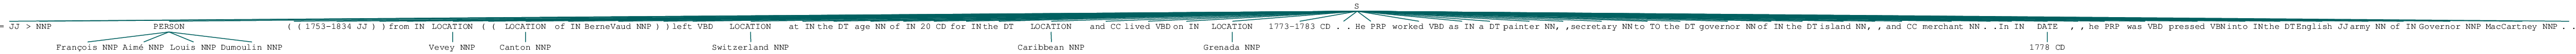

In [8]:
tree_text = stanford_tree(bio_text)
tree_text

In [11]:
# Function imported from 
# https://pythonprogramming.net/using-bio-tags-create-named-entity-lists/?completed=/testing-stanford-ner-taggers-for-speed/

# Parse named entities from tree
def structure_ne(ne_tree):
	ne = []
	for subtree in ne_tree:
		if type(subtree) == Tree: # If subtree is a noun chunk, i.e. NE != "O"
			ne_label = subtree.label()
			ne_string = " ".join([token for token, pos in subtree.leaves()])
			ne.append((ne_string, ne_label))
		else:
			ne_label = 'O'
			ne_string = subtree[0]
			ne.append((ne_string, ne_label))           
	return ne

In [12]:
clean_ne = structure_ne(tree_text)
clean_ne

[('=', 'O'),
 ('>', 'O'),
 ('François Aimé Louis Dumoulin', 'PERSON'),
 ('(', 'O'),
 ('1753-1834', 'O'),
 (')', 'O'),
 ('from', 'O'),
 ('Vevey', 'LOCATION'),
 ('(', 'O'),
 ('Canton', 'LOCATION'),
 ('of', 'O'),
 ('BerneVaud', 'O'),
 (')', 'O'),
 ('left', 'O'),
 ('Switzerland', 'LOCATION'),
 ('at', 'O'),
 ('the', 'O'),
 ('age', 'O'),
 ('of', 'O'),
 ('20', 'O'),
 ('for', 'O'),
 ('the', 'O'),
 ('Caribbean', 'LOCATION'),
 ('and', 'O'),
 ('lived', 'O'),
 ('on', 'O'),
 ('Grenada', 'LOCATION'),
 ('1773–1783', 'O'),
 ('.', 'O'),
 ('He', 'O'),
 ('worked', 'O'),
 ('as', 'O'),
 ('a', 'O'),
 ('painter', 'O'),
 (',', 'O'),
 ('secretary', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('governor', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('island', 'O'),
 (',', 'O'),
 ('and', 'O'),
 ('merchant', 'O'),
 ('.', 'O'),
 ('In', 'O'),
 ('1778', 'DATE'),
 (',', 'O'),
 ('he', 'O'),
 ('was', 'O'),
 ('pressed', 'O'),
 ('into', 'O'),
 ('the', 'O'),
 ('English', 'O'),
 ('army', 'O'),
 ('of', 'O'),
 ('Governor', 'O'),
 ('MacCartn

In [13]:
def ner_text(text):
    tokenized_text = word_tokenize(text)
    classified_text = st.tag(tokenized_text)
    bio_text = bio_tagger(classified_text)
    tree_text = stanford_tree(bio_text)
    ner_item = structure_ne(tree_text)
    return ner_item

# From NE tree to JSON

The structure NE list for each text is transformed into an entry in a dataframe. The goal is to have for each sample of text an entry with the *relevant* informations.  
The difficult part is to sort the relevant informations. Which of the persons is the one of interest? Which location is the location where the organization or the person was involved? Which dates are the dates of interest? 
Here we deal only with the transformation.

## Use schema 1 **(*name* (date) from *origin*)** to retrieve JSON names, origins and dates attributes in the text item.

In [18]:
#Input:
#Output: 
#Requirements: 
#Description: 
def is_date(dateString):
    return any(s.isdigit() for s in dateString)
#Works for (1731-1820)

In [232]:
#Input: item is a single entry from text source 1 with NER tags (characterized by the '=>' starting string)
#Output: True is the text is structured as schema 1, False otherwise
#Requirements: is_date() function
#Description: Test if the first elements of a text match the schema 1. Namely, does the first words match the  **Name** (*date*) from *city* pattern.
def schema1_test(item):
    tags = [x[1] for x in item]
    text_middle= [x[0] for x in item]
    #start and end of piece of interest
    schema1 = False
    try:
        person_Index = tags.index('PERSON')
    except ValueError:
        person_Index = 1 #default
        print("List does not contain value")
    try: 
        location_Index = tags.index('LOCATION')
    except ValueError:
        print("List does not contain value")
        location_Index = 0 #default
    if person_Index < location_Index:
        ner_middle = tmp[person_Index+1:location_Index-1]
    #digit test
    digit_test = any(x.isdigit() for x in text_middle)
    #parenthesis test
    if digit_test :
        schema1 = ('(' and ')') in text_middle#parenthesis test

    return schema1

In [233]:
#Function test
schema1_test(ner_text(text_items[80]))

True

## Compute how many items follow the **(*name* (date) from *origin*)** schema (schema 1)

In [155]:
s1_items= []
i = 0
s1 = 0
for item in text_items:
    ner_item = ner_text(item)
    #print(ner_item[0:8])
    #print(str(i)+'\n')
    i = i+1
    if schema1_test(ner_item):
        s1 = s1 + 1
        print(f'Total schema1 found: {s1}')
        s1_items.append(ner_item)

Total schema1 found: 1
Total schema1 found: 2
Total schema1 found: 3
Total schema1 found: 4
List does not contain value
Total schema1 found: 5
List does not contain value
Total schema1 found: 6
Total schema1 found: 7
Total schema1 found: 8
Total schema1 found: 9
Total schema1 found: 10
Total schema1 found: 11
Total schema1 found: 12
List does not contain value
Total schema1 found: 13
Total schema1 found: 14
Total schema1 found: 15
List does not contain value
Total schema1 found: 16
Total schema1 found: 17
Total schema1 found: 18
Total schema1 found: 19
List does not contain value
Total schema1 found: 20
Total schema1 found: 21
Total schema1 found: 22
Total schema1 found: 23
Total schema1 found: 24
Total schema1 found: 25
Total schema1 found: 26
Total schema1 found: 27
Total schema1 found: 28
Total schema1 found: 29
Total schema1 found: 30
List does not contain value
Total schema1 found: 31
Total schema1 found: 32
Total schema1 found: 33
Total schema1 found: 34
Total schema1 found: 35
L

List does not contain value
Total schema1 found: 256
Total schema1 found: 257
List does not contain value
Total schema1 found: 258
Total schema1 found: 259
Total schema1 found: 260
Total schema1 found: 261
Total schema1 found: 262
Total schema1 found: 263
Total schema1 found: 264
Total schema1 found: 265
Total schema1 found: 266
Total schema1 found: 267
Total schema1 found: 268
Total schema1 found: 269
Total schema1 found: 270
Total schema1 found: 271
Total schema1 found: 272
Total schema1 found: 273
Total schema1 found: 274
Total schema1 found: 275
Total schema1 found: 276
Total schema1 found: 277
List does not contain value
Total schema1 found: 278
Total schema1 found: 279
Total schema1 found: 280
List does not contain value
Total schema1 found: 281
Total schema1 found: 282
Total schema1 found: 283
Total schema1 found: 284
Total schema1 found: 285
Total schema1 found: 286
Total schema1 found: 287
List does not contain value
Total schema1 found: 288
Total schema1 found: 289
Total sche

In [322]:
s1_tot = len(s1_items)
print(f'With the new function we found {s1_tot} items following schema 1.\n\nOne example is : {s1_items[6]}\n')

With the new function we found 322 items following schema 1.

One example is : [('=', 'O'), ('>', 'O'), ('In', 'O'), ('1677', 'DATE'), (',', 'O'), ('Swiss', 'O'), ('medical', 'O'), ('doctor', 'O'), ('Felix Christian Spoerri', 'PERSON'), ('(', 'O'), ('1615-1680', 'O'), (')', 'O'), ('from', 'O'), ('Zurich', 'LOCATION'), ('wrote', 'O'), ('a', 'O'), ('detailed', 'O'), ('description', 'O'), ('of', 'O'), ('Barbados', 'LOCATION'), ('(', 'O'), ('«', 'O'), ('Americanische', 'O'), ('Reiss-Beschreibung', 'O'), ('nach', 'O'), ('den', 'O'), ('Caribes', 'O'), ('Insslen', 'O'), (',', 'O'), ('und', 'O'), ('Neu-Engelland', 'O'), ('»', 'O'), (')', 'O'), (',', 'O'), ('which', 'O'), ('he', 'O'), ('had', 'O'), ('visited', 'O'), ('in', 'O'), ('1661', 'DATE'), ('and', 'O'), ('1662', 'DATE'), (',', 'O'), ('including', 'O'), ('the', 'O'), ('slavery', 'O'), ('economy', 'O'), (',', 'O'), ('which', 'O'), ('produced', 'O'), ('sugar', 'O'), (',', 'O'), ('tobacco', 'O'), (',', 'O'), ('cotton', 'O'), (',', 'O'), ('an

In [323]:
perc_s1 = s1_tot/items_total*100
print(f'The amount of items following schema 1 are {perc_s1:2.0f}%.')

The amount of items following schema 1 are 69%.


### Visual inspections of schema 1 items

In [324]:
s1_items

[[('=', 'O'),
  ('>', 'O'),
  ('Arthur Thellusson', 'PERSON'),
  (',', 'O'),
  ('son', 'O'),
  ('of', 'O'),
  ('Lord', 'O'),
  ('Rendlesham', 'O'),
  ('and', 'O'),
  ('grandson', 'O'),
  ('of', 'O'),
  ('Peter Thellusson', 'PERSON'),
  (',', 'O'),
  ('born', 'O'),
  ('into', 'O'),
  ('a', 'O'),
  ('Geneva', 'LOCATION'),
  ('banking', 'O'),
  ('family', 'O'),
  (',', 'O'),
  ('who', 'O'),
  ('had', 'O'),
  ('bought', 'O'),
  ('the', 'O'),
  ('original', 'O'),
  ('Brodsworth Hall', 'PERSON'),
  ('estate', 'O'),
  ('in', 'O'),
  ('South Yorkshire', 'LOCATION'),
  ('(', 'O'),
  ('GB', 'O'),
  (')', 'O'),
  ('in', 'O'),
  ('1790', 'DATE'),
  (',', 'O'),
  ('married', 'O'),
  ('the', 'O'),
  ('daughter', 'O'),
  ('of', 'O'),
  ('Antigua', 'LOCATION'),
  ('slave', 'O'),
  ('owner', 'O'),
  ('Sir', 'O'),
  ('Christopher Bethell-Codrington', 'PERSON'),
  ('.', 'O')],
 [('=', 'O'),
  ('>', 'O'),
  ('In', 'O'),
  ('her', 'O'),
  ('book', 'O'),
  ('A', 'O'),
  ('Small', 'O'),
  ('Place', 'O'),
  (

## From NER to JSON

In [368]:
#Input: item is a single entry from text source 1 with NER tags (characterized by the '=>' starting string)
#Output: A JSON string with Person,Date,Location keys if is the text is structured as schema 1, None otherwise
#Requirements: is_date() function
#Description: Test if the first elements of a text match the schema 1. 
#Namely, does the first words match the  **Name** (*date*) from *city* pattern.
#If it matches schema1 it returns a dictionary 
def schema1_JSON(item):
    s1item_JSON = None
    tags = [x[1] for x in item]
    text = [x[0] for x in item]
    
    #start and end of piece of interest, i.e. 'PERSON'.....'LOCATION'
    schema1 = False
    try:
        person_Index = tags.index('PERSON')
    except ValueError:
        person_Index = -1 #default
        print("Item does not contain a PERSON value")
   
    try: 
        location_Index = tags.index('LOCATION')
    except ValueError:
        print("Item does not contain a LOCATION value")
        location_Index = -1 #default
   
    #If there are PERSON and LOCATION values, with PERSON first we continue the schema1 test
    if person_Index < location_Index and person_Index > 0 and location_Index > 0 :
        #define part in between PER and LOC tags
        ner_middle = item[person_Index+1:location_Index-1]
        text_middle = [x[0] for x in ner_middle]
        
        #parenthesis test
        try:
            par1_Index = text_middle.index('(')
        except ValueError:
            par1_Index = -1 #default
        print("par 1 index" + str(par1_Index))
              
        try:
            par2_Index = text_middle.index(')')
        except ValueError:
            par2_Index = -1 #default
        print("par 2 index" + str(par2_Index))
    
        if par1_Index < par2_Index and par2_Index >= 0 and par1_Index >= 0 :
            date_par = text_middle[par1_Index+1:par2_Index]
            print('This is the text in between parenthesis ' +str(date_par))
            #digit test
            digit_test = any(x.isdigit() for x in str(date_par))
            print('The digit test results : '+str(digit_test))
            #Save informations from schema 1
            if digit_test :
                
                #retrieve date
                date = ''
                date_split = str(date_par).split('–')
                for x in str(date_split):
                    if x.isdigit():
                        date = date +' '+ x
                print('The retrieved date is ' + date)
                #retrieve location and person values
                location = item[location_Index][0]
                person = item[person_Index][0]
        
            #Create a JSON dictionary
                s1item_JSON = {
                    'person' : person,
                    'date': date,
                    'location': location,
                #'field':NA
                }
    return s1item_JSON

In [369]:
#Function test
n = 30 
print(text_items[n])
schema1_JSON(ner_text(text_items[n]))

=> Jean Huguenin (1685–1740) from Le Locle (Canton of Neuchâtel) moved to Holland with Swiss troops. His son Jean Roulof Huguenin (1731-1764) became ensign in the regiment Douglas, a military unit which had been sent to Berbice to suppress the slave rising of 1763. Lieutenant Colonel Robert Douglas was a Scotsman at the service of the Dutch army and the second in command in the expedition against the rebellious slaves. Huguenin died in Berbice and is buried in Fort Nassau.

par 1 index0
par 2 index2
This is the text in between parenthesis ['1685–1740']
The digit test results : True
The retrieved date is  1 6 8 5 1 7 4 0


{'person': 'Jean Huguenin', 'date': ' 1 6 8 5 1 7 4 0', 'location': 'Holland'}

In [365]:
any(x.isdigit() for x in '1685–1740')
'1685–1740'.split('–')

['1685', '1740']

## Create JSON from schema 1 items

In [320]:
s1_JSON= []
i = 0
s1 = 0
for item in text_items:
    ner_item = ner_text(item)
    print(ner_item[0:8])
    #print(str(i)+'\n')
    i = i+1
    json = schema1_JSON(ner_item)
    print(json)
    s1_JSON.append(json)

[('=', 'O'), ('>', 'O'), ('Arthur Thellusson', 'PERSON'), (',', 'O'), ('son', 'O'), ('of', 'O'), ('Lord', 'O'), ('Rendlesham', 'O')]
None
[('=', 'O'), ('>', 'O'), ('In', 'O'), ('her', 'O'), ('book', 'O'), ('A', 'O'), ('Small', 'O'), ('Place', 'O')]
None
[('=', 'O'), ('>', 'O'), ('Hans Conrad Hottinger', 'PERSON'), ('(', 'O'), ('Hottinguer', 'O'), (')', 'O'), ('(', 'O'), ('1764–1841', 'O')]
None
[('=', 'O'), ('>', 'O'), ('Hans Conrad Hottinger', 'PERSON'), ('’', 'O'), ('s', 'O'), ('business', 'O'), ('partner', 'O'), ('was', 'O')]
None
[('=', 'O'), ('>', 'O'), ('Marx Rütimeyer\u200f\u200e ( b', 'ORGANIZATION'), ('.', 'O'), ('1647', 'O'), (')', 'O'), ('from', 'O'), ('Vinelz ( Canton of Berne )', 'ORGANIZATION')]
List does not contain value
None
[('=', 'O'), ('>', 'O'), ('In', 'O'), ('1718', 'DATE'), (',', 'O'), ('Captain Woodes Rogers (', 'ORGANIZATION'), ('1679-1732', 'O'), (')', 'O')]
List does not contain value
None
[('=', 'O'), ('>', 'O'), ('In', 'O'), ('1677', 'DATE'), (',', 'O'), ('

KeyboardInterrupt: 

In [310]:
s1_JSON_clean = [] 
for val in s1_JSON:
    if val != None :
        s1_JSON_clean.append(val)

In [316]:
s1_JSON_clean

[{'person': 'Grafen Karl von Zinzendorf',
  'date': '1764',
  'location': 'Switzerland'},
 {'person': 'Grafen Karl von Zinzendorf',
  'date': '1764',
  'location': 'Switzerland'},
 {'person': 'Neuchâtel', 'date': '3715001757', 'location': 'Berbice'},
 {'person': 'Isaac du Thon', 'date': '1709', 'location': 'Canton'},
 {'person': 'Pierre Antoine Charbon', 'date': '1762', 'location': 'Canton'},
 {'person': 'Adam Charbon', 'date': '1750', 'location': 'Amsterdam'},
 {'person': 'David Amstein', 'date': '500', 'location': 'River Berbice'},
 {'person': 'Jourdan', 'date': '8250117921795', 'location': 'Basel'},
 {'person': 'Abraham Zubli', 'date': '1760', 'location': 'New Amsterdam'},
 {'person': 'Francis Amick', 'date': '1780', 'location': 'Switzerland'},
 {'person': 'Grafen Karl von Zinzendorf',
  'date': '1764',
  'location': 'Switzerland'},
 {'person': 'John Law', 'date': '1717', 'location': 'Bürglen'},
 {'person': 'Christophe Jean Baur', 'date': '1786', 'location': 'Geneva'},
 {'person': '

Exceptions, errors etc..

In [297]:
#some have '>' as person 
len(s1_JSON_clean)
#s1_JSON_clean[1]

#some have 'Canton' or 'City' instead of location

75

## Remove duplicate
If some entries have the samed person we need to merge or remove one of the entry.

In [231]:
s1_items[10]

[('=', 'O'),
 ('>', 'O'),
 ('Jean-Antoine Bertrand (', 'PERSON'),
 ('1726-1780', 'O'),
 (')', 'O'),
 ('from', 'O'),
 ('the', 'O'),
 ('City', 'LOCATION'),
 ('of', 'O'),
 ('Geneva', 'LOCATION'),
 ('became', 'O'),
 ('a', 'O'),
 ('merchant', 'O'),
 ('in', 'O'),
 ('Dominica', 'LOCATION'),
 ('in', 'O'),
 ('1764', 'DATE'),
 (',', 'O'),
 ('his', 'O'),
 ('brother', 'O'),
 ('Charles (', 'PERSON'),
 ('born', 'O'),
 ('1716', 'O'),
 (')', 'O'),
 ('followed', 'O'),
 ('him', 'O'),
 ('in', 'O'),
 ('1775', 'DATE'),
 ('.', 'O'),
 ('Together', 'O'),
 ('they', 'O'),
 ('bought', 'O'),
 ('properties', 'O'),
 ('in', 'O'),
 ('St. Patrick', 'LOCATION'),
 ('and', 'O'),
 ('St.', 'O'),
 ('David Parishes', 'PERSON'),
 (',', 'O'),
 ('including', 'O'),
 ('an', 'O'),
 ('estate', 'O'),
 ('in', 'O'),
 ('Grand Bay', 'LOCATION'),
 ('which', 'O'),
 ('they', 'O'),
 ('called', 'O'),
 ('«', 'O'),
 ('Geneva', 'LOCATION'),
 ('»', 'O'),
 ('after', 'O'),
 ('the', 'O'),
 ('family', 'O'),
 ('’', 'O'),
 ('s', 'O'),
 ('former', 'O')


## Get location when mentioned further to deal with : from the city of...

## Use section name to retrieve JSON colonial location attribute

To do 

## Use predefined categories to retrieve the JSON type attribute 

To do 

# Scratch

### Old version of schema 1 test
This version is outdated. To restrictive it gets only 18 items.

In [52]:
#Input: item is a single entry from text source 1 with NER tags (characterized by the '=>' starting string)
#Output: True is the text is structured as schema 1, False otherwise
#Requirements: is_date() function
#Description: Test if the first elements of a text match the schema 1. Namely, does the first words match the  **Name** (*date*) from *city* pattern.
def schema1_test(item): 
    testValue = (item[2][1] == ('PERSON' or 'ORGANIZATION)')) and (item[3][0] == '(') and (is_date(item[4][0]) == True) and (item[5][0] == ')') and (item[6][0] == 'from') and (item[7][1] == 'LOCATION')
    return testValue

schema1_test(clean_ne)

What about multiple persons in a paragraph?
    -> one ID per person with same organization groups etc...

In [ ]:
dataSet = pd.DataFrame({
                     'id':[],
                     'person':[],
                     'location':[],
                     'period':[],})
dataSet.

In [ ]:
person_list = []

for ent in tokens.ents:
    if ent.label_ == 'PERSON':
        person_list.append(ent.text)
        
person_counts = Counter(person_list).most_common(20)
df_person = pd.DataFrame(person_counts, columns =['text', 'count'])

In [ ]:
len(classified_text)

In [ ]:
json